# Boosting Algorithms
Project for testing and comparing various boosting algorithms

## Datasets
We use two datasets - one for regression and other for classification.

### Regression dataset
Source: https://archive.ics.uci.edu/ml/datasets/Superconductivty+Data

Contains 81 numerical features that determine the critical temperature of a superconductor. The target is the critical temperature.

### Classification dataset
Source: https://archive.ics.uci.edu/ml/datasets/QSAR+biodegradation

Contains 21 numerical features, which are the molecular attributes of 1055 chemicals. The label is a class either RB (readily biodegradable) or NRB (non-readily biodegradable)

## Loading Data

In [ ]:
!wget 'https://raw.githubusercontent.com/profsarang/ThinkingDataScience/main/data/superconductors.csv'

--2022-08-27 07:16:45--  https://raw.githubusercontent.com/profsarang/ThinkingDataScience/main/data/superconductors.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23859780 (23M) [text/plain]
Saving to: ‘superconductors.csv’

superconductors.csv 100%[===================>]  22.75M   148MB/s    in 0.2s    

2022-08-27 07:16:45 (148 MB/s) - ‘superconductors.csv’ saved [23859780/23859780]



In [ ]:
!wget 'https://raw.githubusercontent.com/profsarang/ThinkingDataScience/main/data/biodeg.csv'

--2022-08-27 07:43:12--  https://raw.githubusercontent.com/profsarang/ThinkingDataScience/main/data/biodeg.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155987 (152K) [text/plain]
Saving to: ‘biodeg.csv.1’

biodeg.csv.1        100%[===================>] 152.33K  --.-KB/s    in 0.02s   

2022-08-27 07:43:12 (6.78 MB/s) - ‘biodeg.csv.1’ saved [155987/155987]



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Preparing datasets

In [ ]:
df1=pd.read_csv('/content/superconductors.csv')          #Regression dataset

In [ ]:
df2=pd.read_csv('/content/biodeg.csv', delimiter=';', header=None)   #Multiclass dataset

Assign names to the columns.

In [ ]:
df2.rename(columns={41:'label'}, inplace=True)

In [ ]:
df2.columns = df2.columns.astype(str)

Set the features and label of the datasets and check their shape:

In [ ]:
features1 = df1.iloc[:,:-1]
label1 = df1.iloc[:,-1]

In [ ]:
features1.shape, label1.shape

((21263, 81), (21263,))

In [ ]:
features2 = df2.iloc[:,:-1]
label2 = df2.iloc[:,-1]

In [ ]:
features2.shape, label2.shape

((1055, 41), (1055,))

###Balancing datasets

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(features2, label2)

In [ ]:
X_res.shape

(1398, 41)

In [ ]:
y_res.value_counts()

RB     699
NRB    699
Name: label, dtype: int64

Encoding categorical columns

In [ ]:
y_res=y_res.replace('NRB',0).replace('RB',1)

In [ ]:
y_res.value_counts()

1    699
0    699
Name: label, dtype: int64

## Creating training/testing datasets

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train1, X_val1, label_train1, label_val1 = train_test_split(features1, label1, test_size=0.20, random_state=42)

In [ ]:
X_train1.shape, X_val1.shape, label_train1.shape, label_val1.shape

((17010, 81), (4253, 81), (17010,), (4253,))

In [ ]:
X_train2, X_val2, label_train2, label_val2 = train_test_split(X_res, y_res , random_state=42, test_size = 0.2)

In [ ]:
X_train2.shape, X_val2.shape, label_train2.shape, label_val2.shape

((1118, 41), (280, 41), (1118,), (280,))

Let us import some fuctions useful to measure the performance of both models:

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def error_metrics(y_pred,y_val):
  print('MSE: ',mean_squared_error(y_pred,y_val))
  print('RMSE: ',np.sqrt(mean_squared_error(y_pred,y_val)))
  print('Coefficient of determination: ',r2_score(y_pred,y_val))

## Random Forest

### Regressor

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

We will evaluate the regressor with 9 ascending number of trees boostrapped, for each one we will compute the oob_error (out of bag error) which in simple words is a measure of the average error in the trees, this will help us plot and find the number of trees where such error is minimum.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
RFreg = RandomForestRegressor(oob_score=True,
                              random_state=42,
                              warm_start=True,
                              n_jobs=-1)
oob_list = list()
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300]:
    RFreg.set_params(n_estimators=n_trees)
    RFreg.fit(X_train1, label_train1)
    oob_error = 1 - RFreg.oob_score_
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')
rf_oob_df

,oob
n_trees,
15.0,0.097827
20.0,0.088971
30.0,0.084432
40.0,0.082569
50.0,0.081271
100.0,0.078429
150.0,0.077568
200.0,0.077095
300.0,0.076590


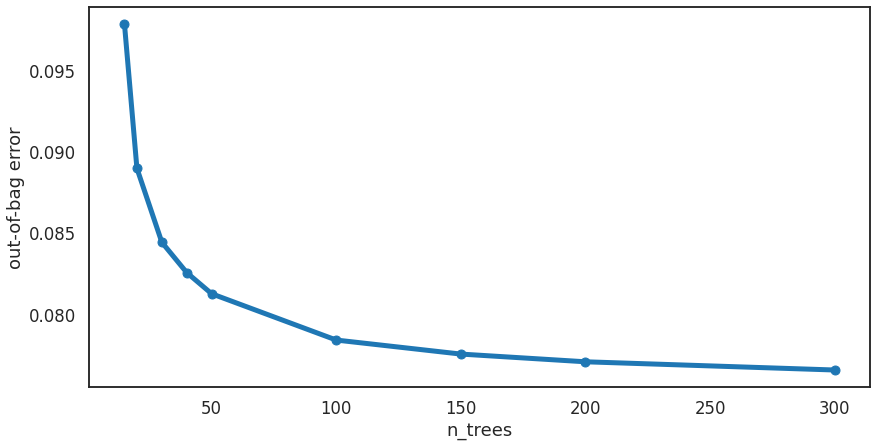

In [ ]:
sns.set_context('talk')
sns.set_style('white')

ax = rf_oob_df.plot(legend=False, marker='o', figsize=(14, 7), linewidth=5)
ax.set(ylabel='out-of-bag error');

Though beyond 150 there is not a significant reduction in error, we will still choose 300 for our testing.

In [ ]:
RFreg_300 = RandomForestRegressor(n_estimators=300
                                  ,oob_score=True 
                                  ,random_state=42
                                  ,n_jobs=-1)

RFreg_300.fit(X_train1, label_train1)
oob_error300 = 1 - RFreg_300.oob_score_
oob_error300

0.07659017671460666

Let us predict the corresponding values for the instances in testing set and compute the error metrics:

In [ ]:
label_pred_reg_rf=RFreg_300.predict(X_val1)

In [ ]:
error_metrics(label_pred_reg_rf,label_val1)

MSE:  80.50827790017327
RMSE:  8.972640519945802
Coefficient of determination:  0.923446110141218


### Classifier

This model will be similar to the previous one, same number of trees and features.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RFcla = RandomForestClassifier(oob_score=True,
                               random_state=42,
                               warm_start=True,
                               n_jobs=-1)
oob_list = list()
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300]:
    RFcla.set_params(n_estimators=n_trees)
    RFcla.fit(X_train2, label_train2)
    oob_error = 1 - RFcla.oob_score_
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')
rf_oob_df

,oob
n_trees,
15.0,0.117174
20.0,0.112701
30.0,0.110018
40.0,0.103757
50.0,0.106440
100.0,0.108229
150.0,0.104651
200.0,0.101968
300.0,0.097496


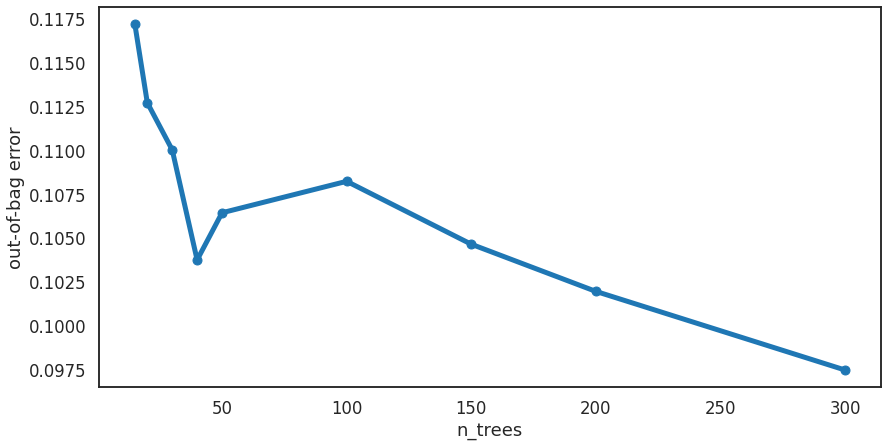

In [ ]:
sns.set_context('talk')
sns.set_style('white')

ax = rf_oob_df.plot(legend=False, marker='o', figsize=(14, 7), linewidth=5)
ax.set(ylabel='out-of-bag error');

This time 300 trees had the lowest error and there was a significant difference with respect to one at 250.

In [ ]:
RFcla_300 = RandomForestClassifier(n_estimators=300
                                  ,oob_score=True 
                                  ,random_state=42
                                  ,n_jobs=-1)

RFcla_300.fit(X_train2, label_train2)
oob_error300 = 1 - RFcla_300.oob_score_
oob_error300

0.0974955277280859

In [ ]:
label_pred_cla_rf=RFcla_300.predict(X_val2)

In [ ]:
print(classification_report(label_val2,label_pred_cla_rf))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93       143
           1       0.92      0.93      0.92       137

    accuracy                           0.93       280
   macro avg       0.92      0.93      0.92       280
weighted avg       0.93      0.93      0.93       280



## AdaBoost

### Regressor

As AdaBoost models requires the setting of 2 hyperparameters we will do so with GridSearchCV which trains the model with all pre-set combinations and finds the one with best score in a metric previously set. We will evaluate 3 different values for the "number of estimators" parameter, 5 learning rates. We use 3 folds cross validation and "coefficient of determination" as scoring.

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV

Adareg = AdaBoostRegressor()

tuned_parameters = {'n_estimators': [50,100,200],'learning_rate':[0.001,0.01,0.1,0.5,0.9]}

Adareg_cv = GridSearchCV(Adareg, tuned_parameters,cv=3,scoring='r2')
Adareg_cv.fit(X_train1, label_train1)

GridSearchCV(cv=3, estimator=AdaBoostRegressor(),
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.5, 0.9],
                         'n_estimators': [50, 100, 200]},
             scoring='r2')

The next function prints the hyperparameters corresponding to the best model found:

In [ ]:
print(Adareg_cv.best_estimator_)

AdaBoostRegressor(learning_rate=0.1, n_estimators=100)


Let us predict the label for the testing instances with the best model and compute the error metrics.

In [ ]:
label_pred_reg_ada=Adareg_cv.predict(X_val1)
error_metrics(label_pred_reg_ada,label_val1)

MSE:  306.58643819666844
RMSE:  17.509609881338545
Coefficient of determination:  0.5115544798427207


In [ ]:
error_metrics(label_pred_reg_ada,label_val1)

MSE:  306.58643819666844
RMSE:  17.509609881338545
Coefficient of determination:  0.5115544798427207


I could never achieve R2 score better than 0.51, mostly attributed to the dataset (81 features with just little over 21000 instances) used in this example.


### Classifier

We will use the same method as before to find the best hyperparameters for the classifier.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

Adacla = AdaBoostClassifier(random_state=42)

tuned_parameters = {'n_estimators': [150,200,300],'learning_rate':[0.4,0.5,0.7]}

Adacla_cv = GridSearchCV(Adacla, tuned_parameters,cv=3,scoring='accuracy')
Adacla_cv.fit(X_train2, label_train2)

GridSearchCV(cv=3, estimator=AdaBoostClassifier(random_state=42),
             param_grid={'learning_rate': [0.4, 0.5, 0.7],
                         'n_estimators': [150, 200, 300]},
             scoring='accuracy')

In [ ]:
print(Adacla_cv.best_estimator_)

AdaBoostClassifier(learning_rate=0.5, n_estimators=200, random_state=42)


In [ ]:
label_pred_cla_ada=Adacla_cv.predict(X_val2)
print(classification_report(label_val2,label_pred_cla_ada))

              precision    recall  f1-score   support

           0       0.92      0.85      0.89       143
           1       0.86      0.93      0.89       137

    accuracy                           0.89       280
   macro avg       0.89      0.89      0.89       280
weighted avg       0.89      0.89      0.89       280



The AdaBoost classifier worked much better reaching almost 0.9 in accuracy. There is a scope to improve as misclassifications are keeping recall and precision low.

## Gradient Boosting

### Regressor

We will not use GridSearchCV here onwards to keep things simple.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

GBR_reg = GradientBoostingRegressor(learning_rate=0.4,
                                    max_depth=3,
                                    n_estimators=300).fit(X_train1, label_train1)



In [ ]:
label_pred_reg_gbr = GBR_reg.predict(X_val1)
error_metrics(label_pred_reg_gbr,label_val1)

MSE:  104.57129253752936
RMSE:  10.2260105875913
Coefficient of determination:  0.9019392826156647


### Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

GBC_cla = GradientBoostingClassifier(learning_rate=0.5,
                                     max_depth=3,
                                     n_estimators=200).fit(X_train2, label_train2)

In [ ]:
label_pred_cla_gbc=GBC_cla.predict(X_val2)
print(classification_report(label_val2,label_pred_cla_gbc))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       143
           1       0.91      0.95      0.93       137

    accuracy                           0.93       280
   macro avg       0.93      0.93      0.93       280
weighted avg       0.93      0.93      0.93       280



Much better performance than than AdaBoost and quite comparable to Random Forest.

## XGBoost

You need to install the library.

In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Regressor

In [ ]:
from xgboost import XGBRegressor

XGB_reg = XGBRegressor(learning_rate=0.4,
                        max_depth=3,
                        n_estimators=300).fit(X_train1, label_train1)



[07:40:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
label_pred_reg_xgb = XGB_reg.predict(X_val1)
error_metrics(label_pred_reg_xgb,label_val1)

MSE:  101.8290694199426
RMSE:  10.091039065425454
Coefficient of determination:  0.9047212957652594


Performance is comparable to the previous model.

### Classifier

In [ ]:
from xgboost import XGBClassifier

XGB_cla = XGBClassifier(learning_rate=0.5,
                        max_depth=3,
                        n_estimators=200).fit(X_train2, label_train2)

In [ ]:
label_pred_cla_xgb=XGB_cla.predict(X_val2)
print(classification_report(label_val2,label_pred_cla_xgb))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       143
           1       0.91      0.93      0.92       137

    accuracy                           0.92       280
   macro avg       0.92      0.92      0.92       280
weighted avg       0.92      0.92      0.92       280



## CatBoost

Supports categorical columns though we do not have any in our current dataset. 

Install the library.

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


### Regressor

The hyperparameters required to set are iterations, learning rate, depth and random_state is optional. The cat_features specifies the names of the categorical columns in a list.

In [ ]:
from catboost import CatBoostRegressor

cat_model_reg = CatBoostRegressor(iterations=300,
                                    learning_rate=0.7,
                                    random_seed=42,
                                    depth=5)

cat_model_reg.fit(X_train1, label_train1, 
                  cat_features=None, 
                  eval_set=(X_val1, label_val1), 
                  verbose=False)

Let us predict the label for the testing instances and compute the error metrics as follows:

In [ ]:
label_pred_reg_cat=cat_model_reg.predict(X_val1)
error_metrics(label_pred_reg_cat,label_val1)

MSE:  98.20372680432128
RMSE:  9.90977935194933
Coefficient of determination:  0.908991565534382


### Classifier

In [ ]:
from catboost import CatBoostClassifier

cat_model_class = CatBoostClassifier(iterations=300,
                                     learning_rate=0.7,
                                     random_seed=42,
                                     depth=3)

cat_model_class.fit(X_train2, label_train2, 
                    cat_features=None, 
                    eval_set=(X_val2, label_val2), 
                    verbose=False)

In [ ]:
label_pred_cla_cat=cat_model_class.predict(X_val2)
print(classification_report(label_val2,label_pred_cla_cat))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93       143
           1       0.90      0.96      0.93       137

    accuracy                           0.93       280
   macro avg       0.93      0.93      0.93       280
weighted avg       0.93      0.93      0.93       280



The performance of this classifier shares the best place with random forest reaching 93% of accuracy.

## LightGBM

Better performance and scalability.

Install the library.

In [ ]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Regressor

In [ ]:
from lightgbm import LGBMRegressor

LGBM_reg = LGBMRegressor(iterations=100,
                         learning_rate=0.3,
                         depth=2)

LGBM_reg.fit(X_train1, label_train1,
             eval_set=(X_val1, label_val1),
             verbose=False)

LGBMRegressor(depth=2, iterations=100, learning_rate=0.3)

In [ ]:
label_pred_reg_lgbm=LGBM_reg.predict(X_val1)
error_metrics(label_pred_reg_lgbm,label_val1)

MSE:  89.05194394188753
RMSE:  9.436733753894275
Coefficient of determination:  0.9170497217299074


### Classifier

In [ ]:
from lightgbm import LGBMClassifier

LGBM_cla = LGBMClassifier(iterations=300,
                          learning_rate=0.4,
                          depth=3)

LGBM_cla.fit(X_train2, label_train2,
             eval_set=(X_val2, label_val2),
             verbose=False)

LGBMClassifier(depth=3, iterations=300, learning_rate=0.4)

In [ ]:
label_pred_cla_lgbm=LGBM_cla.predict(X_val2)
print(classification_report(label_val2,label_pred_cla_lgbm))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93       143
           1       0.92      0.93      0.92       137

    accuracy                           0.93       280
   macro avg       0.92      0.93      0.92       280
weighted avg       0.93      0.93      0.93       280



The performance was the same as the CatBoost.

## Performance comparison

In this step we will show the performance metrics of all regressors and classifiers.

### Regressor

In [ ]:
data = {'Random Forest': [mean_squared_error(label_pred_reg_rf,label_val1),np.sqrt(mean_squared_error(label_pred_reg_rf,label_val1)),r2_score(label_pred_reg_rf,label_val1)],
        'AdaBoost': [mean_squared_error(label_pred_reg_ada,label_val1),np.sqrt(mean_squared_error(label_pred_reg_ada,label_val1)),r2_score(label_pred_reg_ada,label_val1)],
        'Gradient Boosting': [mean_squared_error(label_pred_reg_gbr,label_val1),np.sqrt(mean_squared_error(label_pred_reg_gbr,label_val1)),r2_score(label_pred_reg_gbr,label_val1)],
        'XGBoost': [mean_squared_error(label_pred_reg_xgb,label_val1),np.sqrt(mean_squared_error(label_pred_reg_xgb,label_val1)),r2_score(label_pred_reg_xgb,label_val1)],
        'CatBoost': [mean_squared_error(label_pred_reg_cat,label_val1),np.sqrt(mean_squared_error(label_pred_reg_cat,label_val1)),r2_score(label_pred_reg_cat,label_val1)],
        'LightGBM': [mean_squared_error(label_pred_reg_lgbm,label_val1),np.sqrt(mean_squared_error(label_pred_reg_lgbm,label_val1)),r2_score(label_pred_reg_lgbm,label_val1)]}
 
pd.DataFrame(data, index=['MSE','RMSE','R2 score'])

,Random Forest,AdaBoost,Gradient Boosting,XGBoost,CatBoost,LightGBM
MSE,80.508278,306.586438,104.571293,101.829069,98.203727,89.051944
RMSE,8.972641,17.509610,10.226011,10.091039,9.909779,9.436734
R2 score,0.923446,0.511554,0.901939,0.904721,0.908992,0.917050


Let us print the regression plot of the predicted and actual temperature for the best regressor found "Random Forest":

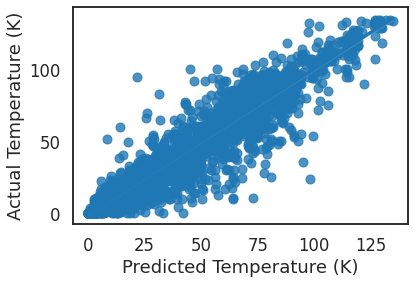

In [ ]:
sns.regplot(x=label_pred_reg_rf, y=label_val1)
plt.xlabel('Predicted Temperature (K)')
plt.ylabel('Actual Temperature (K)')

plt.show()

### Classifier

In [ ]:
metrics = []
models = ['Random Forest', 'AdaBoost', 'Gradient Boosting', 'XGBoost', 'CatBoost', 'LightGBM']
predictions=[label_pred_cla_rf, label_pred_cla_ada, label_pred_cla_gbc, label_pred_cla_xgb,
             label_pred_cla_cat, label_pred_cla_lgbm]

for lab,i in zip(models, predictions):
    precision, recall, fscore, _ = score(label_val2, i, average='weighted')
    accuracy = accuracy_score(label_val2, i)
    auc = roc_auc_score(label_binarize(label_val2, classes=[0,1]),
                        label_binarize(i, classes=[0,1]),
                        average='weighted')
    metrics.append(pd.Series({'precision':precision, 'recall':recall,
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, name=lab))
    
metrics = pd.concat(metrics, axis=1)

In [ ]:
metrics

,Random Forest,AdaBoost,Gradient Boosting,XGBoost,CatBoost,LightGBM
precision,0.925033,0.891884,0.929425,0.918087,0.934026,0.925033
recall,0.925000,0.889286,0.928571,0.917857,0.932143,0.925000
fscore,0.925005,0.889208,0.928571,0.917867,0.932119,0.925005
accuracy,0.925000,0.889286,0.928571,0.917857,0.932143,0.925000
auc,0.925042,0.890077,0.928998,0.918049,0.932801,0.925042


Let us print the confusion matrix of the best classifier found "CatBoost":

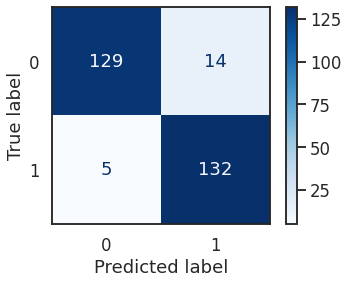

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(label_val2,label_pred_cla_cat), display_labels=cat_model_class.classes_)
disp.plot(cmap='Blues')